In [22]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import find_peaks

In [23]:
# Load the file
# data_file = Path("../Data/0.8mpers-60n-0.8pas.xlsx") # Change this to the appropriate folder/file

data_file = Path("../Data/1.5mpers-30n-11.3pas.xlsx") 
# data_file = Path("../Data/3kn-0.5.xlsx")
# data_file = Path(r"E:\School\Year 3\cheng_lab\Data\0.3mpers-110n-11.3pas.xlsx") 
# data_file = Path(r"..\Data\1mpers-20n-0.8pas.xlsx")
df = pl.read_excel(source=data_file, sheet_name="Analog")

# df = pl.read_excel(source=data_file, sheet_name="Analog #1")

In [24]:
## Parameter you can change
sampling_speed = 1000
speed = 1.5
data_point_length = speed / sampling_speed

In [25]:
## Process the file
header_names = df.columns
x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
df = df.with_columns(
    x_data,
    ((16+pl.col("Voltage")) * 1000).alias("Left Gap [\u03bcm]"),
    ((16+((pl.col("Dev1/ai3")/250*1000)-4)*(10/16))*1000).alias("Right Gap [\u03bcm]"),
    (pl.col("Dev1/ai2")*112.3898+558.30904).alias("Load [N]")
)

print(df.shape[0])

19900


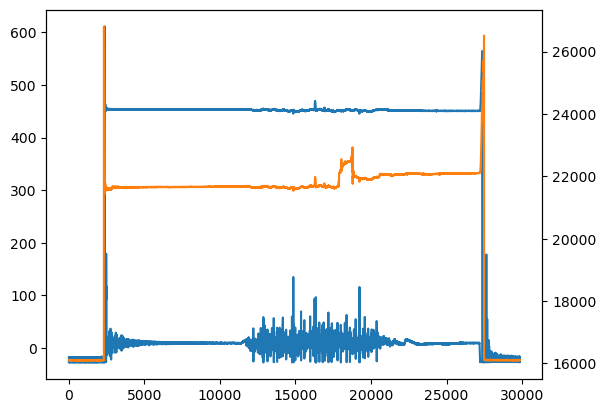

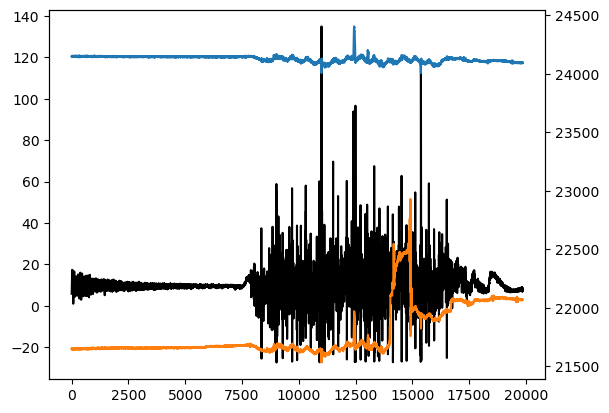

In [26]:
## Remove The Edges
fig, ax1 = plt.subplots()
x_data
ax1.plot(x_data, df["Load [N]"])

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
signal_data = df["Right Gap [\u03bcm]"]
# plt.savefig(f'{data_file}.png')
# display(signal_data)

bound = 1000
left_gap = df["Left Gap [μm]"].to_numpy()
peaks, _ = find_peaks(left_gap)

peaks = sorted(peaks, key=lambda x: left_gap[x], reverse=True)
outlier_index = np.sort(peaks[:2]) # Sort ensures the 0 index is the left point 

start_index, end_index = outlier_index[0] + bound, outlier_index[1] - bound *5 # Take the bound away from the file

fig, ax1 = plt.subplots()

df = df.slice(start_index, end_index) 

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
ax1.plot(x_data, df["Load [N]"], color='k')

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
save_path =  data_file.parent / Path('Cut') / f"{data_file.name}.png"
plt.savefig(save_path)

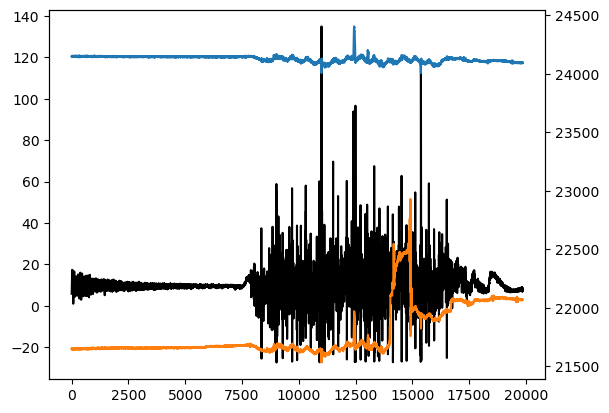

In [18]:
fig, ax1 = plt.subplots()

x_data = pl.Series("Axial Distance [mm]", np.arange(0, df.shape[0]) * data_point_length) * 1000
ax1.plot(x_data, df["Load [N]"], color='k')

ax2 = ax1.twinx()

ax2.plot(x_data, df["Left Gap [\u03bcm]"])
ax2.plot(x_data, df["Right Gap [\u03bcm]"])
save_path =  data_file.parent / Path('Cut') / f"{data_file.name}.png"
plt.savefig(save_path)

Analyzing 13237 data points.
Computing CWT for Left Gap...
Computing CWT for Right Gap...
Detected bump center index: 12965
Detected bump center location (x): 19447.50 mm
Estimated bump start index: 75, x: 112.50 mm
Estimated bump end index:   13163, x: 19744.50 mm
Estimated bump width: 19632.00 mm (13089 data points)


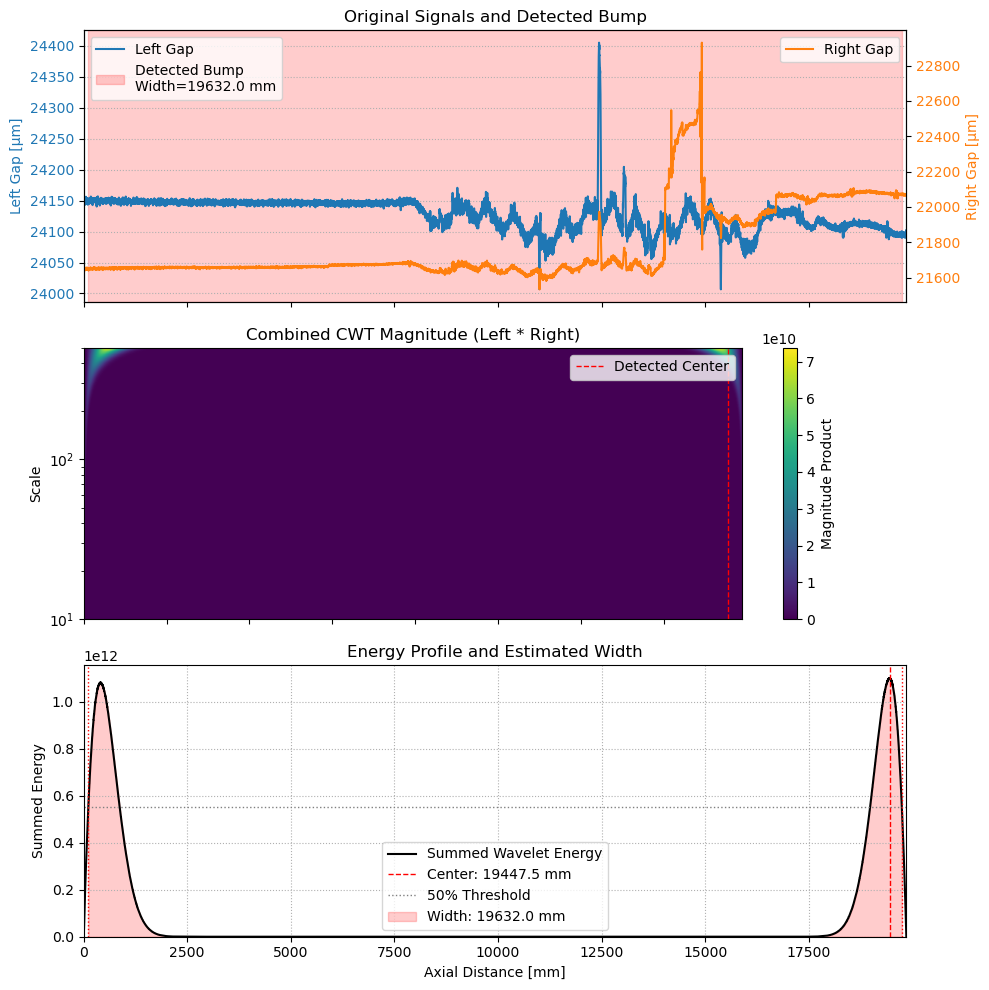

In [20]:
# --- Start Wavelet Analysis ---
import pywt

print(f"Analyzing {df.shape[0]} data points.")

# Extract the signals
left_gap = df["Left Gap [μm]"].to_numpy()
right_gap = df["Right Gap [μm]"].to_numpy()
x_coords = x_data.to_numpy() # Get x-coordinates as numpy array

# Define wavelet and scales
wavelet_name = 'mexh' # Mexican Hat wavelet - good for bumps
# Scales: Cover a range potentially matching the bump width.
# Width ~ 800 indices * 0.001 mm/index * 1000 = 800 mm visually in dummy data
# Scales are inversely related to frequency, somewhat related to width.
# Start with a range, e.g., from small (details) to ~bump width/2
min_scale = 10
max_scale = 500 # Adjust based on expected bump width in samples
num_scales = 100
scales = np.geomspace(min_scale, max_scale, num_scales) # Logarithmic spacing often works well

# --- Compute CWT for both signals ---
print("Computing CWT for Left Gap...")
coeffs_left, freqs_left = pywt.cwt(left_gap, scales, wavelet_name)
print("Computing CWT for Right Gap...")
coeffs_right, freqs_right = pywt.cwt(right_gap, scales, wavelet_name)

# --- Combine CWT magnitudes ---
# Multiply magnitudes to find areas where BOTH signals have high wavelet energy
cwt_magnitude_left = np.abs(coeffs_left)
cwt_magnitude_right = np.abs(coeffs_right)
combined_cwt_magnitude = cwt_magnitude_left * cwt_magnitude_right
# Alternative: Summing -> combined_cwt_magnitude = cwt_magnitude_left + cwt_magnitude_right

# --- Analyze the combined energy ---
# Sum energy across scales for each x-position
energy_profile = np.sum(combined_cwt_magnitude, axis=0)

# Find the index and x-value of the peak energy (bump center)
bump_center_index = np.argmax(energy_profile)
bump_center_x = x_coords[bump_center_index]
peak_energy = energy_profile[bump_center_index]

print(f"Detected bump center index: {bump_center_index}")
print(f"Detected bump center location (x): {bump_center_x:.2f} mm")

# --- Estimate Bump Width ---
# Use a threshold relative to the peak energy (e.g., 50% = Full Width at Half Maximum - FWHM)
threshold_ratio = 0.50
energy_threshold = peak_energy * threshold_ratio

# Find indices where energy is above the threshold
above_threshold_indices = np.where(energy_profile > energy_threshold)[0]

if len(above_threshold_indices) > 0:
    # Find the start and end indices of the contiguous block around the peak
    # This assumes the main bump creates the most significant block above threshold
    start_bump_index = above_threshold_indices[0]
    end_bump_index = above_threshold_indices[-1]

    # Ensure the peak is actually within this range (sanity check for complex profiles)
    if not (start_bump_index <= bump_center_index <= end_bump_index):
       print("Warning: Peak energy index not within the thresholded range. Width estimate might be inaccurate.")
       # Fallback: try finding the block containing the peak index if complex profile
       containing_block = np.split(above_threshold_indices, np.where(np.diff(above_threshold_indices) != 1)[0]+1)
       for block in containing_block:
           if block[0] <= bump_center_index <= block[-1]:
               start_bump_index = block[0]
               end_bump_index = block[-1]
               break

    start_bump_x = x_coords[start_bump_index]
    end_bump_x = x_coords[end_bump_index]
    bump_width_x = end_bump_x - start_bump_x

    # Calculate width in number of points
    bump_width_points = end_bump_index - start_bump_index + 1

    print(f"Estimated bump start index: {start_bump_index}, x: {start_bump_x:.2f} mm")
    print(f"Estimated bump end index:   {end_bump_index}, x: {end_bump_x:.2f} mm")
    print(f"Estimated bump width: {bump_width_x:.2f} mm ({bump_width_points} data points)")
else:
    print("Could not find any region above the energy threshold. Bump not detected or threshold too high.")
    start_bump_index, end_bump_index = -1, -1 # Indicate failure
    start_bump_x, end_bump_x, bump_width_x = np.nan, np.nan, np.nan


# --- Plotting Results ---
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Plot 1: Original Signals
ax1 = axs[0]
color_left = 'tab:blue'
ax1.set_ylabel('Left Gap [\u03bcm]', color=color_left)
ax1.plot(x_coords, left_gap, color=color_left, label='Left Gap')
ax1.tick_params(axis='y', labelcolor=color_left)
ax1.grid(True, axis='y', linestyle=':')

ax1b = ax1.twinx() # instantiate a second axes that shares the same x-axis
color_right = 'tab:orange'
ax1b.set_ylabel('Right Gap [\u03bcm]', color=color_right)
ax1b.plot(x_coords, right_gap, color=color_right, label='Right Gap')
ax1b.tick_params(axis='y', labelcolor=color_right)
ax1.set_title('Original Signals and Detected Bump')

# Shade the detected bump area on the first plot
if not np.isnan(bump_width_x):
    ax1.axvspan(start_bump_x, end_bump_x, color='red', alpha=0.2, label=f'Detected Bump\nWidth={bump_width_x:.1f} mm')
ax1.legend(loc='upper left')
ax1b.legend(loc='upper right')


# Plot 2: Combined CWT Magnitude (Scalogram)
ax2 = axs[1]
im = ax2.imshow(combined_cwt_magnitude, extent=[x_coords[0], x_coords[-1], scales[0], scales[-1]],
                aspect='auto', cmap='viridis', origin='lower')
ax2.set_ylabel('Scale')
ax2.set_title('Combined CWT Magnitude (Left * Right)')
ax2.set_yscale('log') # Scales are often viewed logarithmically
plt.colorbar(im, ax=ax2, label='Magnitude Product')
# Mark center line
ax2.axvline(bump_center_x, color='red', linestyle='--', linewidth=1, label='Detected Center')
ax2.legend(loc='upper right')


# Plot 3: Summed Energy Profile
ax3 = axs[2]
ax3.plot(x_coords, energy_profile, color='k', label='Summed Wavelet Energy')
ax3.axvline(bump_center_x, color='red', linestyle='--', linewidth=1, label=f'Center: {bump_center_x:.1f} mm')
ax3.axhline(energy_threshold, color='grey', linestyle=':', linewidth=1, label=f'{threshold_ratio*100:.0f}% Threshold')
if not np.isnan(bump_width_x):
    ax3.axvline(start_bump_x, color='red', linestyle=':', linewidth=1)
    ax3.axvline(end_bump_x, color='red', linestyle=':', linewidth=1)
    ax3.fill_between(x_coords, 0, energy_profile, where=(x_coords >= start_bump_x) & (x_coords <= end_bump_x),
                     color='red', alpha=0.2, label=f'Width: {bump_width_x:.1f} mm')

ax3.set_xlabel('Axial Distance [mm]')
ax3.set_ylabel('Summed Energy')
ax3.set_title('Energy Profile and Estimated Width')
ax3.legend()
ax3.grid(True, linestyle=':')
ax3.set_ylim(bottom=0) # Energy shouldn't be negative

plt.tight_layout()
# Save the figure if needed
# save_path_wavelet = data_file.parent / Path('Cut') / f"{data_file.name}_wavelet_analysis.png"
# plt.savefig(save_path_wavelet)
plt.show()

Analyzing 13237 data points.
Computing CWT for Left Gap...
Computing CWT for Right Gap...
No significant peaks found in the central region (margin=10.0%, prominence=1.008e+11). Falling back to max energy in center.
Fallback: Detected bump center index: 11911
Fallback: Detected bump center location (x): 17866.50 mm
Estimated bump start index: 11651, x: 17476.50 mm
Estimated bump end index:   13184, x: 19776.00 mm
Estimated bump width: 2299.50 mm (1534 data points)


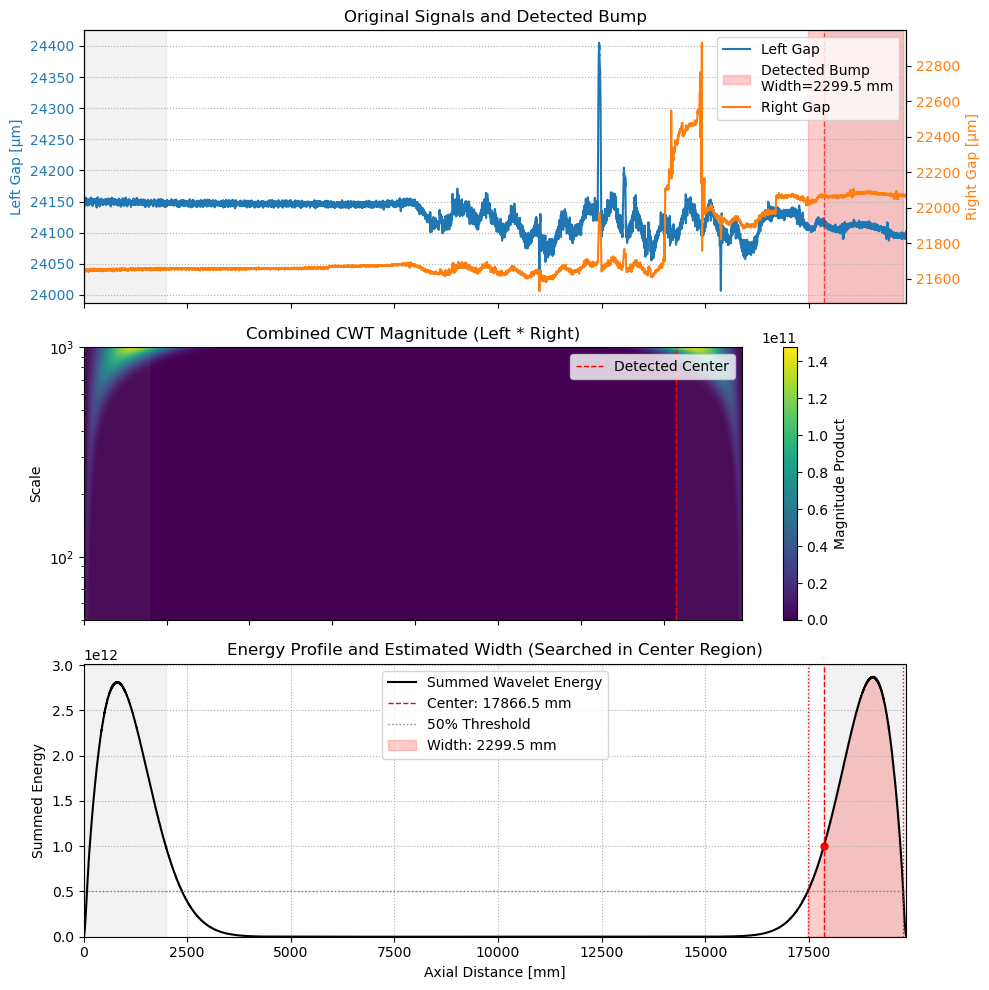

In [28]:
# --- Start Wavelet Analysis ---

print(f"Analyzing {df.shape[0]} data points.")

# Extract the signals
left_gap = df["Left Gap [μm]"].to_numpy()
right_gap = df["Right Gap [μm]"].to_numpy()
x_coords = x_data.to_numpy()

# Define wavelet and scales
wavelet_name = 'mexh'
# Adjust scales based on expected bump width IN SAMPLES
# If bump is ~1500mm wide and data_point_length=1mm/pt, width is ~1500 points
# Scales should bracket this.
min_scale = 50  # Increase min scale to ignore very fine noise
max_scale = 1000 # Max scale ~ bump_width/2 or bump_width
num_scales = 100
scales = np.geomspace(min_scale, max_scale, num_scales)

# --- Compute CWT for both signals ---
print("Computing CWT for Left Gap...")
coeffs_left, freqs_left = pywt.cwt(left_gap, scales, wavelet_name)
print("Computing CWT for Right Gap...")
coeffs_right, freqs_right = pywt.cwt(right_gap, scales, wavelet_name)

# --- Combine CWT magnitudes ---
cwt_magnitude_left = np.abs(coeffs_left)
cwt_magnitude_right = np.abs(coeffs_right)
combined_cwt_magnitude = cwt_magnitude_left * cwt_magnitude_right
# Alternative to consider if multiplication is too sensitive to single large spikes:
# combined_cwt_magnitude = cwt_magnitude_left + cwt_magnitude_right

# --- Analyze the combined energy ---
energy_profile = np.sum(combined_cwt_magnitude, axis=0)

# --- Find Bump Center (Ignoring Edges) ---
edge_margin_ratio = 0.10 # Ignore 10% from each side (adjust as needed)
n_points = len(energy_profile)
start_search_index = int(n_points * edge_margin_ratio)
end_search_index = int(n_points * (1 - edge_margin_ratio))

# Use find_peaks within the central region
central_energy = energy_profile[start_search_index:end_search_index]
central_x_coords = x_coords[start_search_index:end_search_index]

# Set a minimum prominence - requires tuning based on typical energy levels
# Calculate based on the central region's data range or standard deviation
min_prominence = (np.max(central_energy) - np.min(central_energy)) * 0.1 # e.g., 10% of range

peaks_indices_relative, properties = find_peaks(
    central_energy,
    prominence=min_prominence # Filter out small noisy peaks
    # width=... # Optionally add width constraints
)

if len(peaks_indices_relative) > 0:
    # Select the peak with the highest prominence within the central region
    prominences = properties['prominences']
    most_prominent_relative_idx = peaks_indices_relative[np.argmax(prominences)]

    # Convert back to the original index
    bump_center_index = start_search_index + most_prominent_relative_idx
    bump_center_x = x_coords[bump_center_index]
    peak_energy = energy_profile[bump_center_index] # Energy at the detected peak

    print(f"Found {len(peaks_indices_relative)} peaks in central region.")
    print(f"Selected most prominent peak index (relative): {most_prominent_relative_idx}")
    print(f"Detected bump center index (absolute): {bump_center_index}")
    print(f"Detected bump center location (x): {bump_center_x:.2f} mm")
    print(f"Peak energy at center: {peak_energy:.3e}")

else:
    print(f"No significant peaks found in the central region (margin={edge_margin_ratio*100}%, prominence={min_prominence:.3e}). Falling back to max energy in center.")
    # Fallback: find max energy within the central region if find_peaks fails
    if len(central_energy) > 0:
        relative_max_idx = np.argmax(central_energy)
        bump_center_index = start_search_index + relative_max_idx
        bump_center_x = x_coords[bump_center_index]
        peak_energy = energy_profile[bump_center_index]
        print(f"Fallback: Detected bump center index: {bump_center_index}")
        print(f"Fallback: Detected bump center location (x): {bump_center_x:.2f} mm")
    else:
        print("Error: Central region is empty.")
        # Assign default invalid values
        bump_center_index = -1
        bump_center_x = np.nan
        peak_energy = np.nan


# --- Estimate Bump Width (using the correctly identified center) ---
if bump_center_index != -1 and not np.isnan(peak_energy):
    threshold_ratio = 0.50
    energy_threshold = peak_energy * threshold_ratio

    # Find indices where energy is above the threshold
    above_threshold_indices = np.where(energy_profile > energy_threshold)[0]

    if len(above_threshold_indices) > 0:
        # Find the contiguous block of indices above threshold that contains the peak
        # Split the indices into contiguous blocks
        blocks = np.split(above_threshold_indices, np.where(np.diff(above_threshold_indices) != 1)[0]+1)
        found_block = False
        for block in blocks:
            if block[0] <= bump_center_index <= block[-1]:
                start_bump_index = block[0]
                end_bump_index = block[-1]
                found_block = True
                break

        if found_block:
            start_bump_x = x_coords[start_bump_index]
            end_bump_x = x_coords[end_bump_index]
            bump_width_x = end_bump_x - start_bump_x
            bump_width_points = end_bump_index - start_bump_index + 1

            print(f"Estimated bump start index: {start_bump_index}, x: {start_bump_x:.2f} mm")
            print(f"Estimated bump end index:   {end_bump_index}, x: {end_bump_x:.2f} mm")
            print(f"Estimated bump width: {bump_width_x:.2f} mm ({bump_width_points} data points)")
        else:
             print(f"Warning: Peak index {bump_center_index} not found within any block above threshold {energy_threshold:.3e}. Width estimation failed.")
             start_bump_index, end_bump_index = -1, -1
             start_bump_x, end_bump_x, bump_width_x = np.nan, np.nan, np.nan

    else:
        print(f"Could not find any region above the energy threshold {energy_threshold:.3e}. Bump not detected or threshold too high.")
        start_bump_index, end_bump_index = -1, -1
        start_bump_x, end_bump_x, bump_width_x = np.nan, np.nan, np.nan
else:
     print("Bump center not detected, cannot estimate width.")
     start_bump_index, end_bump_index = -1, -1
     start_bump_x, end_bump_x, bump_width_x = np.nan, np.nan, np.nan

# --- Plotting Results ---
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

# Plot 1: Original Signals
ax1 = axs[0]
color_left = 'tab:blue'
ax1.set_ylabel('Left Gap [\u03bcm]', color=color_left)
ax1.plot(x_coords, left_gap, color=color_left, label='Left Gap', lw=1.5)
ax1.tick_params(axis='y', labelcolor=color_left)
ax1.grid(True, axis='y', linestyle=':')

ax1b = ax1.twinx()
color_right = 'tab:orange'
ax1b.set_ylabel('Right Gap [\u03bcm]', color=color_right)
ax1b.plot(x_coords, right_gap, color=color_right, label='Right Gap', lw=1.5)
ax1b.tick_params(axis='y', labelcolor=color_right)
ax1.set_title('Original Signals and Detected Bump')

# Mark the search region
ax1.axvspan(x_coords[0], x_coords[start_search_index], color='grey', alpha=0.1, label='_Edge Excluded')
ax1.axvspan(x_coords[end_search_index], x_coords[-1], color='grey', alpha=0.1, label='_Edge Excluded')


# Shade the detected bump area
if not np.isnan(bump_width_x):
    ax1.axvspan(start_bump_x, end_bump_x, color='red', alpha=0.2, label=f'Detected Bump\nWidth={bump_width_x:.1f} mm')
    # Mark center on top plot too
    ax1.axvline(bump_center_x, color='red', linestyle='--', linewidth=1, alpha=0.7, label='_Center')


# --- Corrected Legend Handling ---
h1, l1 = ax1.get_legend_handles_labels()  # Get handles/labels from ax1
h2, l2 = ax1b.get_legend_handles_labels() # Get handles/labels from ax1b

# Combine handles and labels from both axes
all_handles = h1 + h2
all_labels = l1 + l2

# Filter handles and labels together, keeping only those whose label doesn't start with '_'
filtered_handles = []
filtered_labels = []
for handle, label in zip(all_handles, all_labels):
    # Check if the label is a string before calling startswith, just in case
    if isinstance(label, str) and not label.startswith('_'):
        filtered_handles.append(handle)
        filtered_labels.append(label)

# Create legend using the filtered lists (use ax1 or ax1b, preferably the one on top like ax1b)
if filtered_handles: # Only create legend if there's something public to show
    ax1b.legend(filtered_handles, filtered_labels, loc='best')
# --- End Corrected Legend Handling ---

# Plot 2: Combined CWT Magnitude (Scalogram)
# ... (rest of the plotting code remains the same) ...


# Plot 2: Combined CWT Magnitude (Scalogram)
ax2 = axs[1]
im = ax2.imshow(combined_cwt_magnitude, extent=[x_coords[0], x_coords[-1], scales[0], scales[-1]],
                aspect='auto', cmap='viridis', origin='lower')
ax2.set_ylabel('Scale')
ax2.set_title('Combined CWT Magnitude (Left * Right)')
ax2.set_yscale('log')
plt.colorbar(im, ax=ax2, label='Magnitude Product')
if not np.isnan(bump_center_x):
    ax2.axvline(bump_center_x, color='red', linestyle='--', linewidth=1, label='Detected Center')
ax2.axvspan(x_coords[0], x_coords[start_search_index], color='grey', alpha=0.1)
ax2.axvspan(x_coords[end_search_index], x_coords[-1], color='grey', alpha=0.1)
ax2.legend(loc='upper right')


# Plot 3: Summed Energy Profile
ax3 = axs[2]
ax3.plot(x_coords, energy_profile, color='k', label='Summed Wavelet Energy')
ax3.axvspan(x_coords[0], x_coords[start_search_index], color='grey', alpha=0.1, label='_Edge Excluded')
ax3.axvspan(x_coords[end_search_index], x_coords[-1], color='grey', alpha=0.1, label='_Edge Excluded')

if bump_center_index != -1: # Only add lines/shading if peak was found
    ax3.axvline(bump_center_x, color='red', linestyle='--', linewidth=1, label=f'Center: {bump_center_x:.1f} mm')
    ax3.plot(bump_center_x, peak_energy, 'ro', markersize=5) # Mark the peak

    if not np.isnan(bump_width_x): # Check if width calculation succeeded
        ax3.axhline(energy_threshold, color='grey', linestyle=':', linewidth=1, label=f'{threshold_ratio*100:.0f}% Threshold')
        ax3.axvline(start_bump_x, color='red', linestyle=':', linewidth=1)
        ax3.axvline(end_bump_x, color='red', linestyle=':', linewidth=1)
        ax3.fill_between(x_coords, 0, energy_profile, where=(x_coords >= start_bump_x) & (x_coords <= end_bump_x),
                         color='red', alpha=0.2, label=f'Width: {bump_width_x:.1f} mm')

ax3.set_xlabel('Axial Distance [mm]')
ax3.set_ylabel('Summed Energy')
ax3.set_title('Energy Profile and Estimated Width (Searched in Center Region)')

# Filter legend labels
handles, labels = ax3.get_legend_handles_labels()
filtered_handles = [h for h, l in zip(handles, labels) if not l.startswith('_')]
filtered_labels = [l for l in labels if not l.startswith('_')]
ax3.legend(filtered_handles, filtered_labels, loc='best')

ax3.grid(True, linestyle=':')
ax3.set_ylim(bottom=0)
ax3.set_xlim(x_coords[0], x_coords[-1]) # Ensure x-limits match other plots

plt.tight_layout()
# save_path_wavelet = data_file.parent / Path('Cut') / f"{data_file.name}_wavelet_analysis_v2.png"
# plt.savefig(save_path_wavelet)
plt.show()